In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import corner
import h5py
import keras
from keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [15]:
data_path = './'
filenames = ['LRT_trig_ntuples_2.h5']  # file can be downloaded from https://cernbox.cern.ch/s/QYKbp42p1W6HOp0 (share with egroup)
dataset_names = ["jets", "electrons", "muons", "photons", "MET", "PU"]

In [16]:
# Make a list that contains the ndarrays for each dataset
datasets = []

for filename in filenames:
    with h5py.File(data_path+filename, 'r') as hf:
        jets = hf['jets'][:]
        electrons = hf['electrons'][:]
        muons = hf['muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        PU = hf['PU'][:].reshape(-1, 1, 4)  # Broadcasting PU
        combined_data = np.concatenate([jets, electrons, muons, photons, MET, PU], axis=1)
        datasets.append(combined_data)

In [17]:
# Flatten ndarrays for DNN
flat_datasets = []

for i, data in enumerate(datasets):
    flat_datasets.append(np.reshape(data, newshape=(-1, 84)))

#check for tabular shapes    
for i, data in enumerate(flat_datasets):
    print(data.shape)

(1019220, 84)


In [18]:
#setting number of features 
N = 84 

#remove the rare events where any of the entries is nan
data = data[~np.isnan(data).any(axis=1), :]

# Standardizing the features
data = StandardScaler().fit_transform(data)

print(data)
print(data.shape)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=21)
print(np.isnan(train_data).any())

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

[[-0.96469311 -0.7274264   0.01304539 ...  0.          0.
   0.        ]
 [-0.96469311 -0.7274264   0.01304539 ...  0.          0.
   0.        ]
 [-0.96469311 -0.7274264   0.01304539 ...  0.          0.
   0.        ]
 ...
 [-0.01078135  1.08312964  1.57312377 ...  0.          0.
   0.        ]
 [-0.17583116 -0.63939132 -0.169871   ...  0.          0.
   0.        ]
 [ 1.72366872  2.03102055 -1.28198901 ...  0.          0.
   0.        ]]
(1019023, 84)
False


In [19]:
#starting with the simplest possible AE architecture
# first layer has N nodes = N features
# single hidden (bottleneck) layer with N/2
# final layer N nodes = N features

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(N, activation="tanh"),
      layers.Dense(N//2, activation="tanh"),
      layers.Dense(N//4, activation="tanh"),
      layers.Dense(N//8, activation="tanh"),
      layers.Dense(5, activation="tanh") # bottleneck layer
       ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(N//8, activation="tanh"),
      layers.Dense(N//4, activation="tanh"),
      layers.Dense(N//2, activation="tanh"),
      layers.Dense(N, activation="tanh")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [20]:
opt = keras.optimizers.Adam(learning_rate=0.005)

def mse_loss(y_actual,y_pred):
    custom_loss= keras.losses.mean_squared_error(tf.zeros(shape=tf.shape(z), y_pred)
    return custom_loss

def chi2_loss(y_actual,y_pred):
    custom_loss= keras.losses.mean_squared_error(tf.zeros(shape=tf.shape(z), y_pred)
    return custom_loss

#placeholder for a proper wasserstein distance or K-L divergence
def wasserstein_loss(z, target_mean, target_std):
    return tf.reduce_mean(tf.abs(z - tf.random.normal(shape=tf.shape(z), mean=target_mean, stddev=target_std)))

def autoencoder_loss(x, x_reconstructed, z, lambda_reg):
    # Reconstruction loss
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_reconstructed))
    
    # Wasserstein distance
    target_mean = 0.0
    target_std = 1.0
    wasserstein_dist = wasserstein_loss(z, target_mean, target_std)
    
    # Total loss
    total_loss = reconstruction_loss + lambda_reg * wasserstein_dist
    
    return total_loss

def loss_wrapper(x, x_reconstructed):
    z = autoencoder.encoder(x)
    lambda_reg = 1.0  # Set the desired value for lambda_reg
    return autoencoder_loss(x, x_reconstructed, z, lambda_reg)

autoencoder.compile(optimizer=opt, loss=loss_wrapper)

In [21]:
history = autoencoder.fit(train_data, train_data, 
          epochs=30, 
          batch_size=1024,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/30
797/797 [==============================] - 10s 8ms/step - loss: 1.4780 - val_loss: 1.4712
Epoch 2/30
797/797 [==============================] - 5s 7ms/step - loss: 1.4446 - val_loss: 1.4625
Epoch 3/30
797/797 [==============================] - 5s 6ms/step - loss: 1.4357 - val_loss: 1.4555
Epoch 4/30
797/797 [==============================] - 5s 7ms/step - loss: 1.4281 - val_loss: 1.4480
Epoch 5/30
797/797 [==============================] - 5s 6ms/step - loss: 1.4206 - val_loss: 1.4413
Epoch 6/30
797/797 [==============================] - 6s 7ms/step - loss: 1.4152 - val_loss: 1.4364
Epoch 7/30
797/797 [==============================] - 5s 6ms/step - loss: 1.4105 - val_loss: 1.4323
Epoch 8/30
797/797 [==============================] - 5s 6ms/step - loss: 1.4081 - val_loss: 1.4327
Epoch 9/30
797/797 [==============================] - 5s 6ms/step - loss: 1.4055 - val_loss: 1.4284
Epoch 10/30
797/797 [==============================] - 5s 6ms/step - loss: 1.4025 - val_loss: 1.423

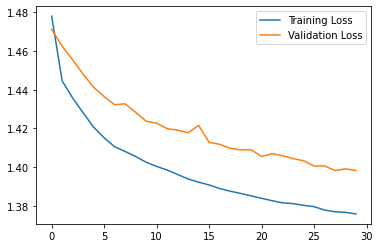

In [22]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
#plt.yscale("log")
plt.legend()

In [1]:
encoded_data = autoencoder.encoder(test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

randIndx = 25

plt.plot(test_data[randIndx], 'b')
#plt.plot(encoded_data[randIndx], 'r')
plt.plot(decoded_data[randIndx], 'r')
#plt.fill_between(np.arange(N), encoded_data[randIndx], test_data[randIndx], color='lightcoral')
plt.fill_between(np.arange(N), decoded_data[randIndx], test_data[randIndx], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

NameError: name 'autoencoder' is not defined

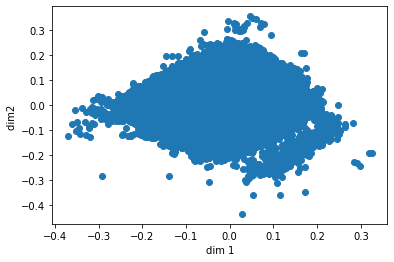

-0.0018622235
-0.0022813873
0.05567471
0.053009596


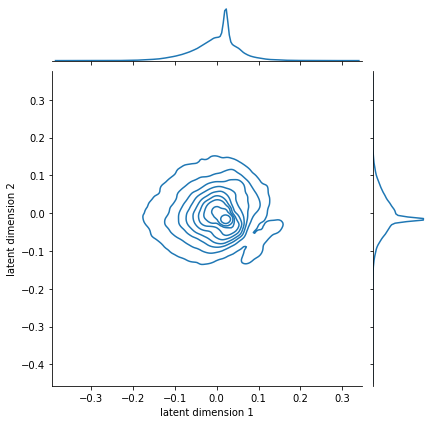

In [24]:
plt.xlabel('dim 1')
plt.ylabel('dim2 ')

plt.scatter(encoded_data[:,0],encoded_data[:,1])
plt.show()

print(np.mean(encoded_data[:,0]))
print(np.mean(encoded_data[:,1]))
print(np.std(encoded_data[:,0]))
print(np.std(encoded_data[:,1]))

df = pd.DataFrame(encoded_data, columns=['latent dimension 1', 'latent dimension 2', 'latent dimension 3', 'latent dimension 4', 'latent dimension 5'])

sns.jointplot(data=df, x="latent dimension 1", y="latent dimension 2", kind="kde")

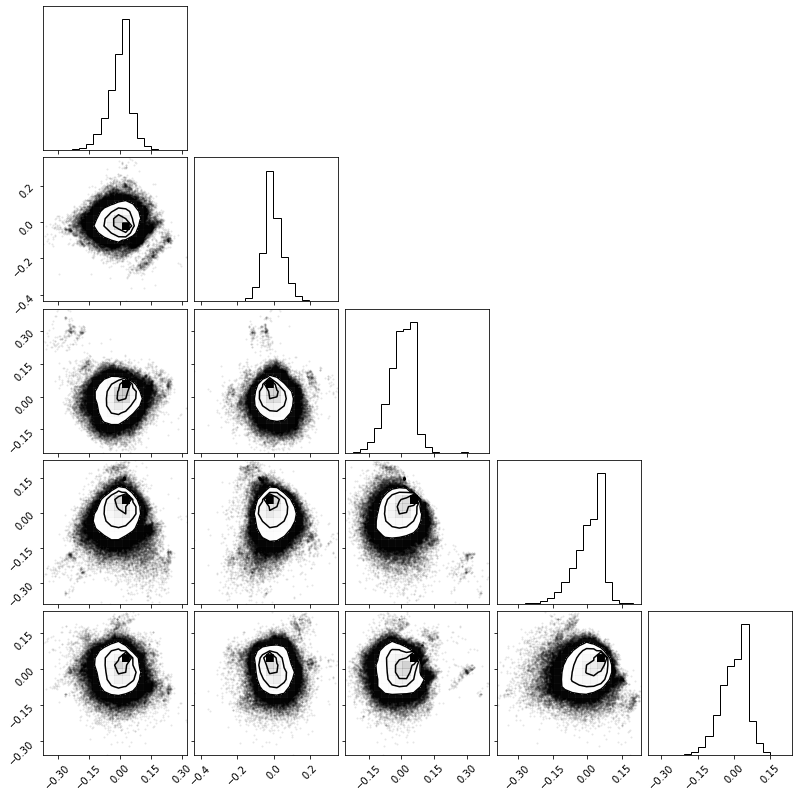

In [25]:
#make a 'corner' plot of the latent space
figure = corner.corner(encoded_data)

25476/25476 [==============================] - 33s 1ms/step


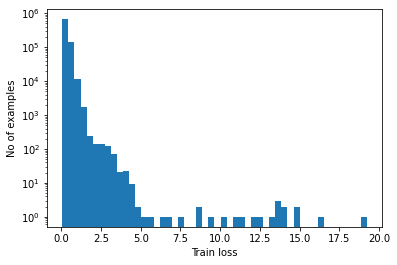

In [26]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.yscale("log")
plt.show()

6369/6369 [==============================] - 10s 1ms/step


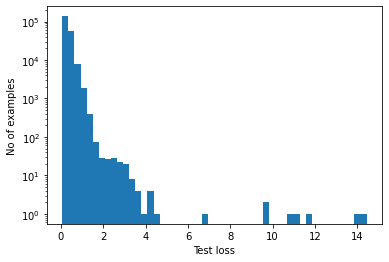

In [27]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.yscale("log")

plt.show()

In [28]:
# explore relationship between PU and reconstruction error
train_data_scores = np.copy(train_data)
train_loss_np = np.array(train_loss)
train_loss_np = train_loss_np.reshape((815218,1) )

print(train_loss_np.shape)
print(train_loss_np)

#print(train_data_scores.shape)
#print(train_data_scores)

train_data_scores = np.concatenate([train_data_scores, train_loss_np], axis=1)
print(train_data_scores.shape)
#print(train_data_scores)

(815218, 1)
[[0.07203168]
 [0.16934557]
 [0.17117973]
 ...
 [0.4053114 ]
 [0.07203168]
 [1.1817348 ]]
(815218, 85)


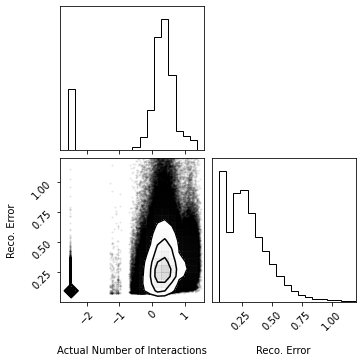

In [29]:
#make a 'corner' plot of a subset of the HLT dataset: the reco erros vs. the number of interactions 

selected_column_ranges = [(80,80),(84,84)] #jet pts and PU vars only for corener plot
selected_columns = np.concatenate([train_data_scores[:, start:end+1] for start, end in selected_column_ranges], axis=1)

figure = corner.corner(selected_columns, labels=["Actual Number of Interactions", "Reco. Error"], range=[(-2.8,1.6), (0.0,1.2) ] )

In [30]:
min_ind = tf.argmin(test_loss)
max_ind = tf.argmax(test_loss)

#print(test_data[min_ind])

In [2]:
ind = min_ind

plt.plot(test_data[ind], 'b')
plt.plot(decoded_data[ind], 'r')
ratio = (test_data[ind] / decoded_data[ind])
#plt.plot(ratio, 'g')

plt.fill_between(np.arange(N), decoded_data[ind], test_data[ind], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
#plt.yscale("log")
plt.show()

NameError: name 'min_ind' is not defined

In [32]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Mean: ", np.mean(train_loss))
print("Threshold: ", threshold)

Mean:  0.30382386
Threshold:  0.51356477


In [33]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [34]:
preds = predict(autoencoder, test_data, threshold)
print(preds)
print_stats(preds, test_labels)

tf.Tensor([ True  True  True ...  True  True  True], shape=(203805,), dtype=bool)


NameError: name 'test_labels' is not defined